# Variable Importance for a Bayesian neural network trained on MNIST

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy.stats import spearmanr

from tensorflow.keras.callbacks import EarlyStopping

# To import scripts from different directory
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, "/".join([parent_dir, "src"]))

from utils import *
from BayesNN_Keras import BNN_Classifier
from rate_bnn import *

/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 1

In [2]:
# Load data - one-hot encoded labels
# Need to crop 5 pixels from the edges of the images to prevent numerical problems with RATE 
crop_size = 5
x_train, y_train, x_test, y_test = load_mnist(True, True, crop_size)
n_train = x_train.shape[0]
n_test = x_test.shape[0]
image_size = int(x_train.shape[1]**0.5)

x_train has shape (60000, 324)
y_train has shape (60000, 10)
x_test has shape (10000, 324)
y_test has shape (10000, 10)


Now train the network and evaluate on the test set using 20 MC samples:

In [3]:
# Architecture
p = x_train.shape[1]
C = y_train.shape[1]

# Training settings
n_epochs = 20
batch_size = 256

# Test settings - the number of posterior samples
n_test_samples = 20

# Network architecture
layers = []
layers.append(tf.keras.layers.Reshape([image_size, image_size, 1], input_shape=(p,)))
layers.append(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
layers.append(tf.layers.Flatten())
layers.append(tf.keras.layers.Dense(512, activation='relu'))
layers.append(tfp.layers.DenseLocalReparameterization(C))

bnn = BNN_Classifier(layers, p, C)
fit_history = bnn.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size,
                      validation_split=0.2,
                     callbacks=[EarlyStopping(monitor="val_acc", patience=2)])

test_score = bnn.score(x_test, y_test, n_test_samples, True)
print("Test set accuracy is {:.4f} pm {} using {:.4f} MC samples".format(test_score[0], test_score[1], n_test_samples))

Instructions for updating:
Colocations handled automatically by placer.
Train on 48000 samples, validate on 12000 samples
Instructions for updating:
Use tf.cast instead.


/home/jsi17/anaconda3/envs/rate-bnn/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Epoch 1/20
48000/48000 [==============================] - 3s 70us/sample - loss: 12600.7207 - acc: 0.9349 - val_loss: 12096.6948 - val_acc: 0.9687
Epoch 2/20
48000/48000 [==============================] - 2s 37us/sample - loss: 11626.5078 - acc: 0.9766 - val_loss: 11158.2395 - val_acc: 0.9748
Epoch 3/20
48000/48000 [==============================] - 2s 38us/sample - loss: 10695.8097 - acc: 0.9818 - val_loss: 10235.9537 - val_acc: 0.9804
Epoch 4/20
48000/48000 [==============================] - 2s 38us/sample - loss: 9782.8469 - acc: 0.9839 - val_loss: 9334.4106 - val_acc: 0.9778
Epoch 5/20
48000/48000 [==============================] - 2s 37us/sample - loss: 8886.1061 - acc: 0.9857 - val_loss: 8448.4233 - val_acc: 0.9783
Test set accuracy is 0.9959 pm 0.00011524811270646751 using 20.0000 MC samples


## Compute RATE values

One RATE value per class per pixel in multi-class case

In [4]:
rate, _ = RATE_BNN(bnn, x_test)

Computing RATE with 324 variables
Variable #: 0 100 200 300 done
Computing RATE with 324 variables
Variable #: 0 100 200 300 done
Computing RATE with 324 variables
Variable #: 0 100 200 300 done
Computing RATE with 324 variables
Variable #: 0 100 200 300 done
Computing RATE with 324 variables
Variable #: 0 100 200 300 done
Computing RATE with 324 variables
Variable #: 0 100 200 300 done
Computing RATE with 324 variables
Variable #: 0 100 200 300 done
Computing RATE with 324 variables
Variable #: 0 100 200 300 done
Computing RATE with 324 variables
Variable #: 0 100 200 300 done
Computing RATE with 324 variables
Variable #: 0 100 200 300 done


# Create Figure A2

This visualises the RATE values for each class/node.

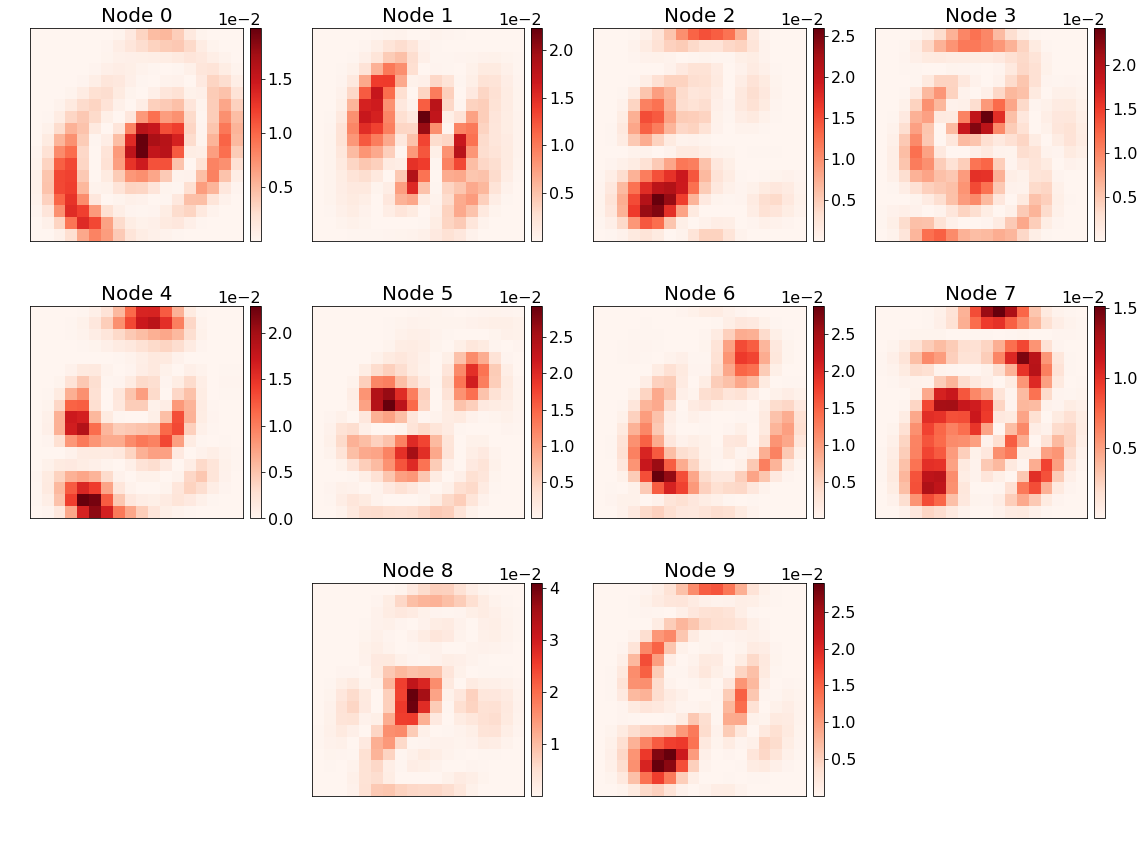

In [5]:
plotsize = 4
tickfontsize = 16
titlefontsize = 20

fig, axes = plt.subplots(3, 4, figsize=(4*plotsize, 3*plotsize))

for c, ax in enumerate(axes.flat[:10]):
    
    if c>7:
        ax = axes.flat[c+1]
    
    im = ax.imshow(rate[c].reshape(image_size, image_size),
              cmap="Reds", interpolation="none")
    
    ax.set_title("Node {}".format(c), fontsize=titlefontsize)
    
    # Colour bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cb = fig.colorbar(im, cax=cax)
    
    cb.formatter.set_scientific(True)
    cb.formatter.set_powerlimits((0, 0))
    cb.ax.yaxis.offsetText.set_fontsize(tickfontsize)
    cb.ax.tick_params("both", labelsize=tickfontsize)
    cb.update_ticks()

    
    # Hide tick labels
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
axes[2,0].axis("off")
axes[2,3].axis("off")

plt.tight_layout()

# Create Figure A3

Test accuracy when shuffling all high-RATE pixels or all low-RATE pixels.

### Shuffling high-RATE pixels

Shuffle any pixel that is significant for any class, where significance is defined as a RATE value strictly larger than $1/p$.

In [ ]:
sig_pixels = np.unique(np.concatenate([np.where(r > 1.0/r.shape[0])[0] for r in rate], axis=0))


n_samples = 20
n_shuffle_repeats = 10
n_selection_repeats = 10


res = {"RATE" : [], "random" : []}

# Select pixels to shuffle according to their RATE values
for _ in range(n_shuffle_repeats):
    x_test_randomised = np.copy(x_test)
    for pix_idx in sig_pixels:
        np.random.shuffle(x_test_randomised[:,pix_idx])
    res["RATE"].append(bnn.score(x_test, y_test, n_samples))

# Select pixels to shuffle at random - the selection step is repeated multiple times
for _ in range(n_selection_repeats):
    reset_pixel_idxs = np.random.choice(p, size=sig_pixels.shape[0], replace=False)
    for _ in range(n_shuffle_repeats):
        x_test_randomised = np.copy(x_test)
        for pix_idx in reset_pixel_idxs:
            np.random.shuffle(x_test_randomised[:,pix_idx])
        res["random"].append(bnn.score(x_test, y_test, n_samples))

### Shuffling low-RATE pixels

In [ ]:
# Performance of classifer shuffling low-RATE pixels
insig_pixels = np.arange(p)[np.in1d(np.arange(p), sig_pixels, invert=True)]

res2 = {"RATE" : [], "random" : []}

# Select pixels to shuffle according to their RATE values
for _ in range(n_shuffle_repeats):
    x_test_randomised = np.copy(x_test)
    for pix_idx in insig_pixels:
        np.random.shuffle(x_test_randomised[:,pix_idx])
    res2["RATE"].append(bnn.score(x_test, y_test, n_samples))

# Select pixels to shuffle at random - the selection step is repeated multiple times
for _ in range(n_selection_repeats):
    reset_pixel_idxs = np.random.choice(p, size=insig_pixels.shape[0], replace=False)
    for _ in range(n_shuffle_repeats):
        x_test_randomised = np.copy(x_test)
        for pix_idx in reset_pixel_idxs:
            np.random.shuffle(x_test_randomised[:,pix_idx])
        res2["random"].append(bnn.score(x_test, y_test, n_samples))

### Create plot

In [ ]:
plotsize = 6
tickfontsize = 20
plottitlesize = 24
axislabelfontsize = 24

fig, axes = plt.subplots(1, 2, figsize=(2*plotsize, plotsize), sharey=True)

# High RATE
df = pd.DataFrame({"All high-RATE\npixels shuffled" : [np.mean(res["RATE"])], "Random pixels\nshuffled" : [np.mean(res["random"])]})

sns.barplot(data=100.0*df, yerr=[200.0*np.std(res["RATE"]), 200.0*np.std(res["random"])], ax=axes[0])
axes[0].set_ylabel("Test set accuracy", fontsize=axislabelfontsize)

axes[0].set_yticklabels(["{} %".format(val) for val in np.arange(0, 17, 2)], fontsize=tickfontsize)

# Low RATE
df = pd.DataFrame({"All low-RATE\npixels shuffled" : [np.mean(res2["RATE"])], "Random pixels\nshuffled" : [np.mean(res2["random"])]})

sns.barplot(data=100.0*df, yerr=[200.0*np.std(res2["RATE"]), 200.0*np.std(res2["random"])], ax=axes[1])
axes[1].set_ylim([0,100])

axes[1].set_yticklabels(["{} %".format(val) for val in np.arange(0, 101, 20)], fontsize=tickfontsize)


for ax in axes:
    ax.axhline(10, color="red", ls="--")
    ax.axhline(98.4, color="green", ls="--")
    ax.tick_params(axis="x", labelsize=axislabelfontsize)
    
for i, l in enumerate(["(A)", "(B)"]):
    axes[i].set_title(l, loc="left", weight="bold", fontsize=plottitlesize)

plt.tight_layout()